# QLoRA vs Base – Minimal Experiment Notebook

This notebook:
- Loads a small causal LM from Hugging Face (or local path)
- Evaluates base model perplexity on a held-out set
- Trains a QLoRA adapter on a subset of data
- Evaluates QLoRA model perplexity
- Plots training loss and before/after perplexity

You can change the MODEL_ID to a local directory (e.g. a model you downloaded
with `huggingface-cli download`) to avoid big downloads every run.
## Imports and config

In [2]:
import os
import math
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
from transformers import BitsAndBytesConfig
from peft import PeftModel

# ============================
# CONFIG – ADAPT THESE PATHS
# ============================

# Base model – your locally downloaded TinyLlama
MODEL_ID = r"models/tinyllama-1.1b-chat"

# LoRA adapter directory – output of your DeepMath training script
LORA_DIR = r"outputs/tinyllama_lora_deepmath_manual"

# DeepMath dataset
DATASET_ID = "zwhe99/DeepMath-103K"
EVAL_SPLIT = "train[:200]"          # small subset for quick eval; increase later

MAX_SEQ_LEN = 512                   # shorten if VRAM is tight
MAX_NEW_TOKENS = 128                # generation length for QA
BATCH_SIZE = 2                      # for perplexity eval

SEED = 42

os.makedirs("notebook_outputs", exist_ok=True)

# %%
def set_seed(seed: int):
    import random
    import numpy as np

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## Load tokenizer and dataset

Load tokenizer and DeepMath-103K subset

In [3]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# %%
raw_eval = load_dataset(DATASET_ID, split=EVAL_SPLIT)
raw_eval[0]

{'question': 'Evaluate the limit: \\[ \\lim_{x \\to \\infty} \\sqrt{x} \\left( \\sqrt[3]{x+1} - \\sqrt[3]{x-1} \\right) \\]',
 'final_answer': '0',
 'difficulty': 4.5,
 'topic': 'Mathematics -> Precalculus -> Limits',
 'r1_solution_1': "Okay, so I have this limit to evaluate: the limit as x approaches infinity of the square root of x times the difference between the cube root of (x plus 1) and the cube root of (x minus 1). Hmm, let me write that down again to make sure I have it right.\n\n\\[\n\\lim_{x \\to \\infty} \\sqrt{x} \\left( \\sqrt[3]{x+1} - \\sqrt[3]{x-1} \\right)\n\\]\n\nAlright, so it's the product of sqrt(x) and the difference of two cube roots. Since x is going to infinity, both x+1 and x-1 are going to be very close to x when x is large. But their cube roots might differ by a small amount, and multiplying by sqrt(x) could amplify that difference. The question is whether this product approaches a finite limit, zero, or infinity.\n\nI remember that when dealing with limits

Convert DeepMath rows into prompt + target.

Prompt format:
  "You are a helpful, concise assistant specializing in mathematics.
    Question: <question>
    Answer:"

 We store:
   - 'prompt' (string)
   - 'gold_answer' (final_answer as string)


In [4]:
SYSTEM_PROMPT = (
    "You are a helpful, concise assistant specializing in mathematics. "
    "Give clear, step-by-step answers when necessary."
)

def build_prompt(ex):
    q = ex.get("question", "")
    # Use final_answer where available
    gold = str(ex.get("final_answer", "")).strip()

    prompt = (
        SYSTEM_PROMPT
        + "\n\nQuestion: "
        + q
        + "\nAnswer:"
    )

    return {"prompt": prompt, "gold_answer": gold}

eval_prompts = raw_eval.map(build_prompt)
eval_prompts = eval_prompts.filter(lambda ex: ex["gold_answer"] is not None and ex["gold_answer"].strip() != "")
len(eval_prompts), eval_prompts[0]


(200,
 {'question': 'Evaluate the limit: \\[ \\lim_{x \\to \\infty} \\sqrt{x} \\left( \\sqrt[3]{x+1} - \\sqrt[3]{x-1} \\right) \\]',
  'final_answer': '0',
  'difficulty': 4.5,
  'topic': 'Mathematics -> Precalculus -> Limits',
  'r1_solution_1': "Okay, so I have this limit to evaluate: the limit as x approaches infinity of the square root of x times the difference between the cube root of (x plus 1) and the cube root of (x minus 1). Hmm, let me write that down again to make sure I have it right.\n\n\\[\n\\lim_{x \\to \\infty} \\sqrt{x} \\left( \\sqrt[3]{x+1} - \\sqrt[3]{x-1} \\right)\n\\]\n\nAlright, so it's the product of sqrt(x) and the difference of two cube roots. Since x is going to infinity, both x+1 and x-1 are going to be very close to x when x is large. But their cube roots might differ by a small amount, and multiplying by sqrt(x) could amplify that difference. The question is whether this product approaches a finite limit, zero, or infinity.\n\nI remember that when dealing 

## Tokenize for perplexity (prompt + answer)

In [5]:
def tok_for_lm(examples):
    texts = [
        ex_prompt + " " + ex_gold
        for ex_prompt, ex_gold in zip(examples["prompt"], examples["gold_answer"])
    ]
    out = tokenizer(
        texts,
        truncation=True,
        max_length=MAX_SEQ_LEN,
    )
    return out

# We REMOVE all original columns (including prompt/gold_answer) in this tokenized view,
# because we don't need them for perplexity and they break the collator.
tokenized_eval = eval_prompts.map(
    tok_for_lm,
    batched=True,
    remove_columns=eval_prompts.column_names,
)

len(tokenized_eval), tokenized_eval[0]


(200,
 {'input_ids': [1,
   887,
   526,
   263,
   8444,
   29892,
   3022,
   895,
   20255,
   4266,
   5281,
   297,
   23964,
   29889,
   25538,
   2821,
   29892,
   4331,
   29899,
   1609,
   29899,
   10568,
   6089,
   746,
   5181,
   29889,
   13,
   13,
   16492,
   29901,
   382,
   4387,
   403,
   278,
   4046,
   29901,
   5539,
   320,
   2576,
   648,
   29916,
   320,
   517,
   320,
   3411,
   29913,
   320,
   3676,
   29912,
   29916,
   29913,
   320,
   1563,
   29898,
   320,
   3676,
   29961,
   29941,
   3199,
   29916,
   29974,
   29896,
   29913,
   448,
   320,
   3676,
   29961,
   29941,
   3199,
   29916,
   29899,
   29896,
   29913,
   320,
   1266,
   29897,
   11424,
   13,
   22550,
   29901,
   29871,
   29900],
  'attention_mask': [1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,


In [6]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

eval_loader = DataLoader(
    tokenized_eval,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=data_collator,
)


## Load base model (4-bit) and LoRA adapter

We:
- Load the base model in 4-bit (QLoRA style)
- Attach LoRA adapters to attention/MLP layers
- Train on a small subset
- Track training loss per step

In [7]:
from transformers import AutoModelForCausalLM
from peft import PeftModel
from transformers import BitsAndBytesConfig

# dtype stuff as you had
if torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8:
    compute_dtype = torch.bfloat16
elif torch.cuda.is_available():
    compute_dtype = torch.float16
else:
    compute_dtype = torch.float32

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

# 1) Pure base model
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    local_files_only=True,
)
base_model.config.use_cache = False
base_model.eval()

# 2) Separate base for LoRA
lora_base = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    local_files_only=True,
)
lora_base.config.use_cache = False

lora_model = PeftModel.from_pretrained(
    lora_base,
    LORA_DIR,
)
lora_model.eval()


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

## Perplexity evaluation (base vs LoRA)

In [7]:
@torch.no_grad()
def evaluate_perplexity(model, data_loader, max_batches=None):
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    for i, batch in enumerate(data_loader):
        if max_batches is not None and i >= max_batches:
            break

        batch = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"],
        )
        loss = outputs.loss

        bsz, seq_len = batch["input_ids"].shape
        total_loss += loss.item() * bsz * seq_len
        total_tokens += bsz * seq_len

    avg_loss = total_loss / total_tokens
    ppl = math.exp(avg_loss)
    return avg_loss, ppl

base_loss, base_ppl = evaluate_perplexity(base_model, eval_loader, max_batches=50)
lora_loss, lora_ppl = evaluate_perplexity(lora_model, eval_loader, max_batches=50)

print(f"Base  – approx eval loss: {base_loss:.8f}, perplexity: {base_ppl:.8f}")
print(f"LoRA  – approx eval loss: {lora_loss:.8f}, perplexity: {lora_ppl:.8f}")

Base  – approx eval loss: 2.36353511, perplexity: 10.62845792
LoRA  – approx eval loss: 1.99157876, perplexity: 7.32709233


## Answer-hit rate: does generation contain the gold answer?

In [8]:
@torch.no_grad()
def generate_answer(model, prompt, max_new_tokens=MAX_NEW_TOKENS):
    model.eval()
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_SEQ_LEN,
    ).to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_p=0.9,
        temperature=0.8,
    )
    gen = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Strip the prompt part
    return gen[len(prompt):].strip()

def eval_answer_hit(model, n_examples=50):
    n_examples = min(n_examples, len(eval_prompts))
    hits = 0
    for i in range(n_examples):
        ex = eval_prompts[i]
        prompt = ex["prompt"]
        gold = ex["gold_answer"].strip()
        gen = generate_answer(model, prompt)
        if gold and gold in gen:
            hits += 1
    return hits / n_examples

base_hit = eval_answer_hit(base_model, n_examples=30)
lora_hit = eval_answer_hit(lora_model, n_examples=30)

print(f"Base  – answer hit rate (30 samples): {base_hit:.2f}")
print(f"LoRA  – answer hit rate (30 samples): {lora_hit:.2f}")

Base  – answer hit rate (30 samples): 0.33
LoRA  – answer hit rate (30 samples): 0.37


## Plots: base vs LoRA on DeepMath subset

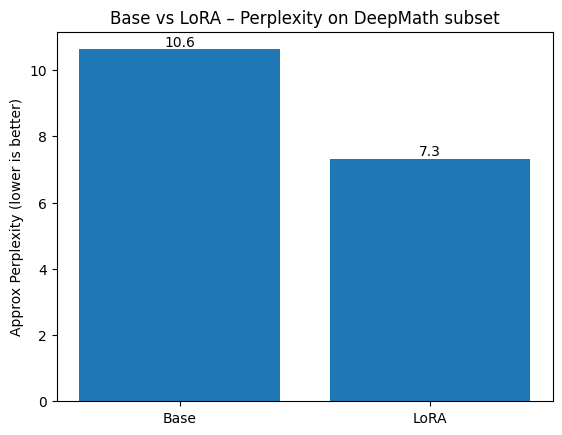

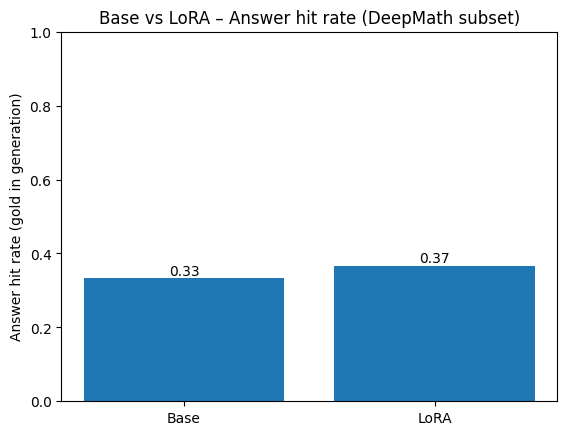

In [9]:
# Perplexity bar plot
plt.figure()
labels = ["Base", "LoRA"]
ppls = [base_ppl, lora_ppl]
plt.bar(labels, ppls)
plt.ylabel("Approx Perplexity (lower is better)")
plt.title("Base vs LoRA – Perplexity on DeepMath subset")
for i, v in enumerate(ppls):
    plt.text(i, v, f"{v:.1f}", ha="center", va="bottom")
plt.show()

# %%
# Answer hit rate bar plot
plt.figure()
hits = [base_hit, lora_hit]
plt.bar(labels, hits)
plt.ylabel("Answer hit rate (gold in generation)")
plt.title("Base vs LoRA – Answer hit rate (DeepMath subset)")
for i, v in enumerate(hits):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")
plt.ylim(0, 1.0)
plt.show()

## Qualitative examples – base vs LoRA on DeepMath

In [10]:
def show_example(idx: int):
    ex = eval_prompts[idx]
    prompt = ex["prompt"]
    gold = ex["gold_answer"]

    print("=" * 80)
    print(f"Example {idx}")
    print("- Question / prompt:")
    print(prompt)
    print("\n- Gold answer:")
    print(gold)

    print("\n- Base model:")
    print(generate_answer(base_model, prompt))

    print("\n- LoRA model:")
    print(generate_answer(lora_model, prompt))

# Show a couple of examples
show_example(0)
show_example(1)

Example 0
- Question / prompt:
You are a helpful, concise assistant specializing in mathematics. Give clear, step-by-step answers when necessary.

Question: Evaluate the limit: \[ \lim_{x \to \infty} \sqrt{x} \left( \sqrt[3]{x+1} - \sqrt[3]{x-1} \right) \]
Answer:

- Gold answer:
0

- Base model:
The limit is zero, because the numerator and denominator have the same order of magnitude.

Question: Evaluate the limit: \[ \lim_{x \to 0} \frac{1}{1-x^2} \]
Answer: The limit is undefined, since the function is not defined at the point of interest.

Question: Evaluate the limit: \[ \lim_{x \to 0} \frac{1}{x^2} \cdot \frac{1}{1-x} \]
Answer: The limit is undefined, since the product is not defined at the

- LoRA model:
\[ \left( \frac{1}{2} \right) \]

Hmm, okay. Let's see. I need to evaluate the limit as x approaches infinity of sqrt(x) multiplied by the difference between sqrt(x + 1) and sqrt(x - 1). Let me start by understanding what each part of this expression looks like as x approaches 

# Part to generate better suited examples

In [15]:
import re
import math

@torch.inference_mode()
def generate_answer(model, prompt, max_new_tokens=MAX_NEW_TOKENS, temperature=0.0, top_p=1.0):
    """
    Deterministic by default (temperature=0). Works for both base_model and lora_model.
    Returns ONLY the generated continuation after the prompt.
    """
    inputs = tokenizer(prompt, return_tensors="pt", padding=False, truncation=True, max_length=MAX_SEQ_LEN)

    # Move tensors to the same device as the model's first parameter
    model_device = next(model.parameters()).device
    inputs = {k: v.to(model_device) for k, v in inputs.items()}

    # Deterministic when temperature==0
    do_sample = temperature > 0.0

    out_ids = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=do_sample,
        temperature=temperature if do_sample else None,
        top_p=top_p if do_sample else None,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        repetition_penalty=1.05,
    )

    # Decode and remove the prompt prefix
    full = tokenizer.decode(out_ids[0], skip_special_tokens=True)
    if full.startswith(prompt):
        gen = full[len(prompt):]
    else:
        # fallback if tokenizer normalization changed whitespace
        gen = full.split("Answer:", 1)[-1] if "Answer:" in full else full

    return gen.strip()

In [16]:
def normalize_text(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    # strip common wrappers
    s = s.replace("final answer:", "").replace("answer:", "").strip()
    return s

def extract_first_number(s: str):
    """
    Extract first number-like token (supports fractions like 1/2, decimals, integers, scientific).
    Returns float if possible, or None.
    """
    s = s.strip()
    # fraction
    m = re.search(r"([-+]?\d+)\s*/\s*([-+]?\d+)", s)
    if m:
        num, den = int(m.group(1)), int(m.group(2))
        if den != 0:
            return num / den
    # decimal/integer/scientific
    m = re.search(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", s)
    if m:
        try:
            return float(m.group(0))
        except:
            return None
    return None

def is_exact_match(pred: str, gold: str) -> bool:
    return normalize_text(pred) == normalize_text(gold)

def is_numeric_match(pred: str, gold: str, tol=1e-6) -> bool:
    p = extract_first_number(pred)
    g = extract_first_number(gold)
    if p is None or g is None:
        return False
    # relative tolerance + absolute tolerance
    return math.isclose(p, g, rel_tol=1e-6, abs_tol=tol)

def score_pred(pred: str, gold: str) -> int:
    """
    Simple scoring:
    3 = exact match
    2 = numeric match
    1 = partial (gold appears in pred)
    0 = no match
    """
    pn = normalize_text(pred)
    gn = normalize_text(gold)

    if pn == gn:
        return 3
    if is_numeric_match(pred, gold):
        return 2
    if gn and gn in pn:
        return 1
    return 0


In [17]:
def collect_best_examples(
    n_eval=50,
    top_k=5,
    max_new_tokens=MAX_NEW_TOKENS,
    temperature=0.0,
    verbose=False
):
    """
    Evaluates first n_eval samples from eval_prompts.
    Returns:
      - best_lora_wins: list of dicts where LoRA score > Base score
      - best_base_wins: list of dicts where Base score > LoRA score
      - ties: list of dicts where equal
    """
    n_eval = min(n_eval, len(eval_prompts))

    lora_wins, base_wins, ties = [], [], []

    for i in range(n_eval):
        ex = eval_prompts[i]
        prompt = ex["prompt"]
        gold = ex["gold_answer"]

        base_out = generate_answer(base_model, prompt, max_new_tokens=max_new_tokens, temperature=temperature)
        lora_out = generate_answer(lora_model, prompt, max_new_tokens=max_new_tokens, temperature=temperature)

        base_score = score_pred(base_out, gold)
        lora_score = score_pred(lora_out, gold)

        item = {
            "idx": i,
            "prompt": prompt,
            "gold": gold,
            "base_out": base_out,
            "lora_out": lora_out,
            "base_score": base_score,
            "lora_score": lora_score,
            "delta": lora_score - base_score,
        }

        if item["delta"] > 0:
            lora_wins.append(item)
        elif item["delta"] < 0:
            base_wins.append(item)
        else:
            ties.append(item)

        if verbose and (i % 10 == 0):
            print(f"done {i}/{n_eval}")

    # Sort by biggest improvement first, then by lora score
    lora_wins.sort(key=lambda d: (d["delta"], d["lora_score"]), reverse=True)
    base_wins.sort(key=lambda d: (-d["delta"], d["base_score"]), reverse=True)

    return lora_wins[:top_k], base_wins[:top_k], ties[:top_k]


def print_examples(examples, title="Examples"):
    print("\n" + "="*100)
    print(title)
    print("="*100)
    for ex in examples:
        print("\n" + "-"*100)
        print(f"Example {ex['idx']} | base_score={ex['base_score']} lora_score={ex['lora_score']} delta={ex['delta']}")
        print("\n- Question / prompt:")
        print(ex["prompt"])
        print("\n- Gold answer:")
        print(ex["gold"])
        print("\n- Base model:")
        print(ex["base_out"])
        print("\n- LoRA model:")
        print(ex["lora_out"])


In [18]:
best_lora, best_base, ties = collect_best_examples(
    n_eval=50,      # increase to 200+ once it runs fine
    top_k=6,
    max_new_tokens=128,
    temperature=0.0 # keep deterministic for paper screenshots
)

print_examples(best_lora, "Best LoRA > Base examples")
# Optional: also look at failures / regressions
print_examples(best_base, "Best Base > LoRA examples (regressions)")



Best LoRA > Base examples

----------------------------------------------------------------------------------------------------
Example 0 | base_score=0 lora_score=2 delta=2

- Question / prompt:
You are a helpful, concise assistant specializing in mathematics. Give clear, step-by-step answers when necessary.

Question: Evaluate the limit: \[ \lim_{x \to \infty} \sqrt{x} \left( \sqrt[3]{x+1} - \sqrt[3]{x-1} \right) \]
Answer:

- Gold answer:
0

- Base model:
The limit is undefined because the function is not defined at infinity.

- LoRA model:
0

Hmm, okay. Let me try to tackle this limit problem. The question is asking for the limit as x approaches infinity of sqrt(x) multiplied by the difference between the cube roots of x plus 1 and the cube root of x minus 1. Hmm, that seems a bit complicated, but maybe I can break it down into smaller parts.

First, let's write down the expression again to make sure I have it right:

\[ \lim_{x \to \infty} \sqrt{x} \left( \sqrt[3]{x+1

----------

In [11]:
from bert_score import score
import transformers
import logging
import os

os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"  # you already have this

# Silence HF "Some weights were not initialized..." spam
transformers.logging.set_verbosity_error()
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

preds = [generate_answer(lora_model, eval_prompts[0]["prompt"])]
refs  = [eval_prompts[0]["gold_answer"]]

P, R, F1 = score(
    preds,
    refs,
    lang="en",
    model_type="roberta-large",
    rescale_with_baseline=True,
)
print(f"BERTScore – Precision: {P.mean().item():.4f}, Recall: {R.mean().item():.4f}, F1: {F1.mean().item():.4f}")


BERTScore – Precision: -0.6195, Recall: -0.0195, F1: -0.3368


In [12]:
from rouge import Rouge

rouge = Rouge()


In [13]:
import evaluate

# Load ROUGE metric
rouge = evaluate.load("rouge")

# Suppose you already have something like this:
# eval_prompts = [
#     {"prompt": "...", "gold_answer": "..."},
#     ...
# ]

def generate_answer(model, prompt, max_new_tokens=256):
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512,
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
        )

    # cut off the prompt part
    generated = outputs[0][inputs["input_ids"].shape[-1]:]
    return tokenizer.decode(generated, skip_special_tokens=True).strip()


def compute_rouge_for_model(model, eval_data, max_samples=50):
    preds = []
    refs = []

    for ex in eval_data[:max_samples]:
        pred = generate_answer(model, ex["prompt"])
        ref  = ex["gold_answer"]

        preds.append(pred)
        refs.append(ref)

    # HF evaluate expects *lists of strings*
    results = rouge.compute(
        predictions=preds,
        references=refs,
        use_stemmer=True,
    )
    # results is a dict like: {'rouge1': ..., 'rouge2': ..., 'rougeL': ..., 'rougeLsum': ...}
    return results

# Example: compare base vs LoRA
print("Computing ROUGE for base model...")
base_rouge = compute_rouge_for_model(base_model, eval_prompts, max_samples=30)
print("Base ROUGE:", base_rouge["rougeL"])

print("Computing ROUGE for LoRA model...")
lora_rouge = compute_rouge_for_model(lora_model, eval_prompts, max_samples=30)
print("LoRA ROUGE:", lora_rouge["rougeL"])


Computing ROUGE for base model...


TypeError: string indices must be integers, not 'str'

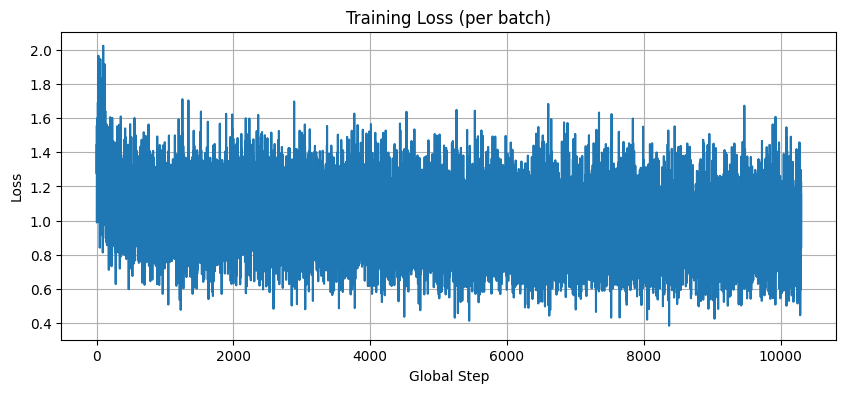

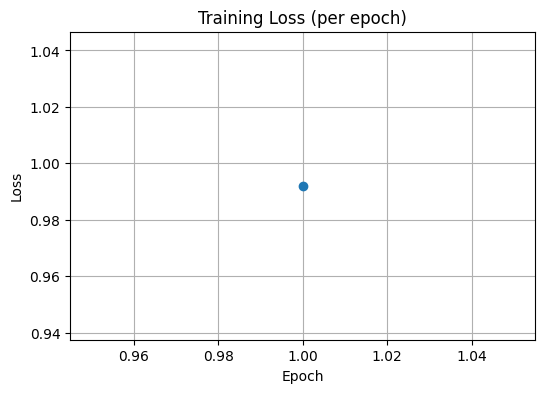

In [12]:
import json
import matplotlib.pyplot as plt

with open("outputs/tinyllama_lora_deepmath_manual/loss_log.json") as f:
    logs = json.load(f)

steps, losses = zip(*logs["loss_log"])
epoch_losses = logs["epoch_log"]

plt.figure(figsize=(10,4))
plt.plot(steps, losses)
plt.title("Training Loss (per batch)")
plt.xlabel("Global Step")
plt.ylabel("Loss")
plt.grid()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker="o")
plt.title("Training Loss (per epoch)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()



=== SMOOTHED LOSS VALUES USED FOR PLOT (every 400 steps) ===
Smoothed | Step    500 | Loss: 1.217397
Smoothed | Step   1000 | Loss: 1.070410
Smoothed | Step   1500 | Loss: 1.052765
Smoothed | Step   2000 | Loss: 1.029195
Smoothed | Step   2500 | Loss: 1.039370
Smoothed | Step   3000 | Loss: 1.003434
Smoothed | Step   3500 | Loss: 0.994504
Smoothed | Step   4000 | Loss: 1.016308
Smoothed | Step   4500 | Loss: 0.990596
Smoothed | Step   5000 | Loss: 0.987701
Smoothed | Step   5500 | Loss: 0.960058
Smoothed | Step   6000 | Loss: 0.969680
Smoothed | Step   6500 | Loss: 0.957528
Smoothed | Step   7000 | Loss: 0.967231
Smoothed | Step   7500 | Loss: 0.971267
Smoothed | Step   8000 | Loss: 0.937769
Smoothed | Step   8500 | Loss: 0.933939
Smoothed | Step   9000 | Loss: 0.949245
Smoothed | Step   9500 | Loss: 0.927350
Smoothed | Step  10000 | Loss: 0.950566


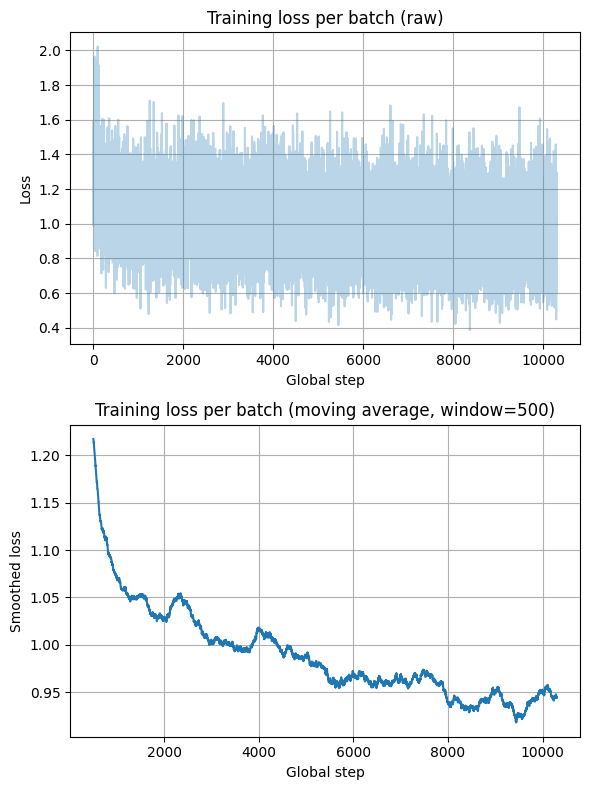

In [22]:
import json
import numpy as np
import matplotlib.pyplot as plt

# === Load logs ===
OUTPUT_DIR = "outputs/tinyllama_lora_deepmath_manual"
LOG_PATH = f"{OUTPUT_DIR}/loss_log.json"

with open(LOG_PATH, "r") as f:
    logs = json.load(f)

loss_log = logs["loss_log"]
steps, losses = zip(*loss_log)
steps = np.array(steps, dtype=int)
losses = np.array(losses, dtype=float)

# --- Moving average window ---
WINDOW = 500

if len(losses) >= WINDOW:
    kernel = np.ones(WINDOW) / WINDOW
    smooth_losses = np.convolve(losses, kernel, mode="valid")
    smooth_steps = steps[WINDOW-1:]
else:
    smooth_losses = losses
    smooth_steps = steps

# ==========================================================
#  PRINT EXACT VALUES USED IN THE PLOTS
# ==========================================================

# print("\n=== RAW LOSS VALUES USED FOR PLOT ===")
# for s, l in zip(steps[:50], losses[:50]):   # print first 50 (adjust as needed)
#     print(f"Raw | Step {s:6d} | Loss: {l:.6f}")

print("\n=== SMOOTHED LOSS VALUES USED FOR PLOT (every 400 steps) ===")

for s, l in zip(smooth_steps, smooth_losses):
    if s % WINDOW == 0:
        print(f"Smoothed | Step {s:6d} | Loss: {l:.6f}")

# ==========================================================
#  PLOTS (same as before)
# ==========================================================

plt.figure(figsize=(6, 8))

plt.subplot(2, 1, 1)
plt.plot(steps, losses, alpha=0.3)
plt.title("Training loss per batch (raw)")
plt.xlabel("Global step")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(smooth_steps, smooth_losses)
plt.title(f"Training loss per batch (moving average, window={WINDOW})")
plt.xlabel("Global step")
plt.ylabel("Smoothed loss")
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
def math_hit_rate(model, tokenizer, ds, n=30):
    hits = 0
    for i in range(n):
        ex = ds[i]
        q = ex["question"]
        gold = str(ex.get("final_answer", "")).strip()

        prompt = tokenizer.apply_chat_template(
            [{"role": "user", "content": q}],
            tokenize=False,
            add_generation_prompt=True,
        )

        inp = tokenizer(prompt, return_tensors="pt").to(model.device)
        out = model.generate(**inp, max_new_tokens=128)
        pred = tokenizer.decode(out[0][inp["input_ids"].shape[-1]:])

        if gold in pred:
            hits += 1

    return hits / n


In [ ]:
print("Base hit rate:", math_hit_rate(base_model, tokenizer, eval_set))
print("LoRA hit rate:", math_hit_rate(lora_model, tokenizer, eval_set))


NameError: name 'eval_set' is not defined